In [76]:
import statsmodels.api as sm
from statsmodels.tsa.api import ARIMA, acf,pacf,seasonal_decompose,adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scripts.data_ingestion import DataIngestion

from helpers.config import load_config
from helpers.logger import logger
from helpers.ts_helper import test_stationary

# load in data

data = DataIngestion(load_config()).fetch_fred_data()

data.head(10)



,FEDFUNDS,date
0,0.80,1954-07-01
1,1.22,1954-08-01
2,1.07,1954-09-01
3,0.85,1954-10-01
4,0.83,1954-11-01
5,1.28,1954-12-01
6,1.39,1955-01-01
7,1.29,1955-02-01
8,1.35,1955-03-01
9,1.43,1955-04-01


- convert to datetime and set index to date

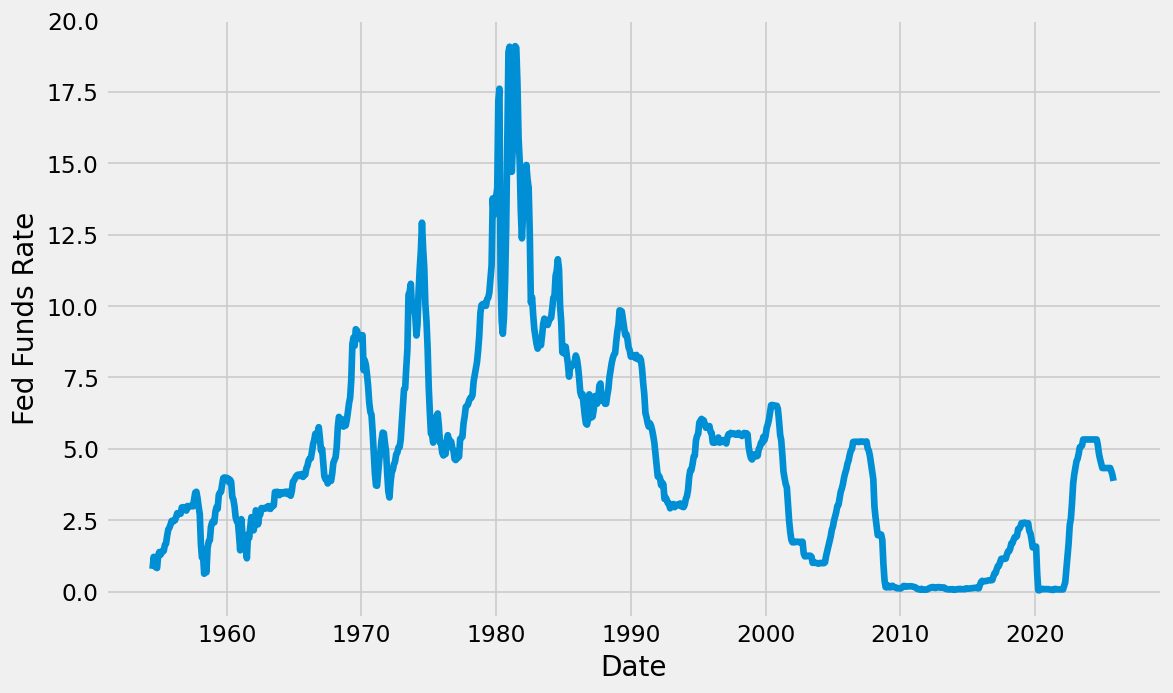

In [77]:
data['date'] = pd.to_datetime(data['date'])

# set index to date
data.set_index("date",inplace=True)

# simple plot
plt.figure(figsize=(10,6))
plt.plot(data)
plt.xlabel("Date")
plt.ylabel("Fed Funds Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

### Adfueller test if stationary

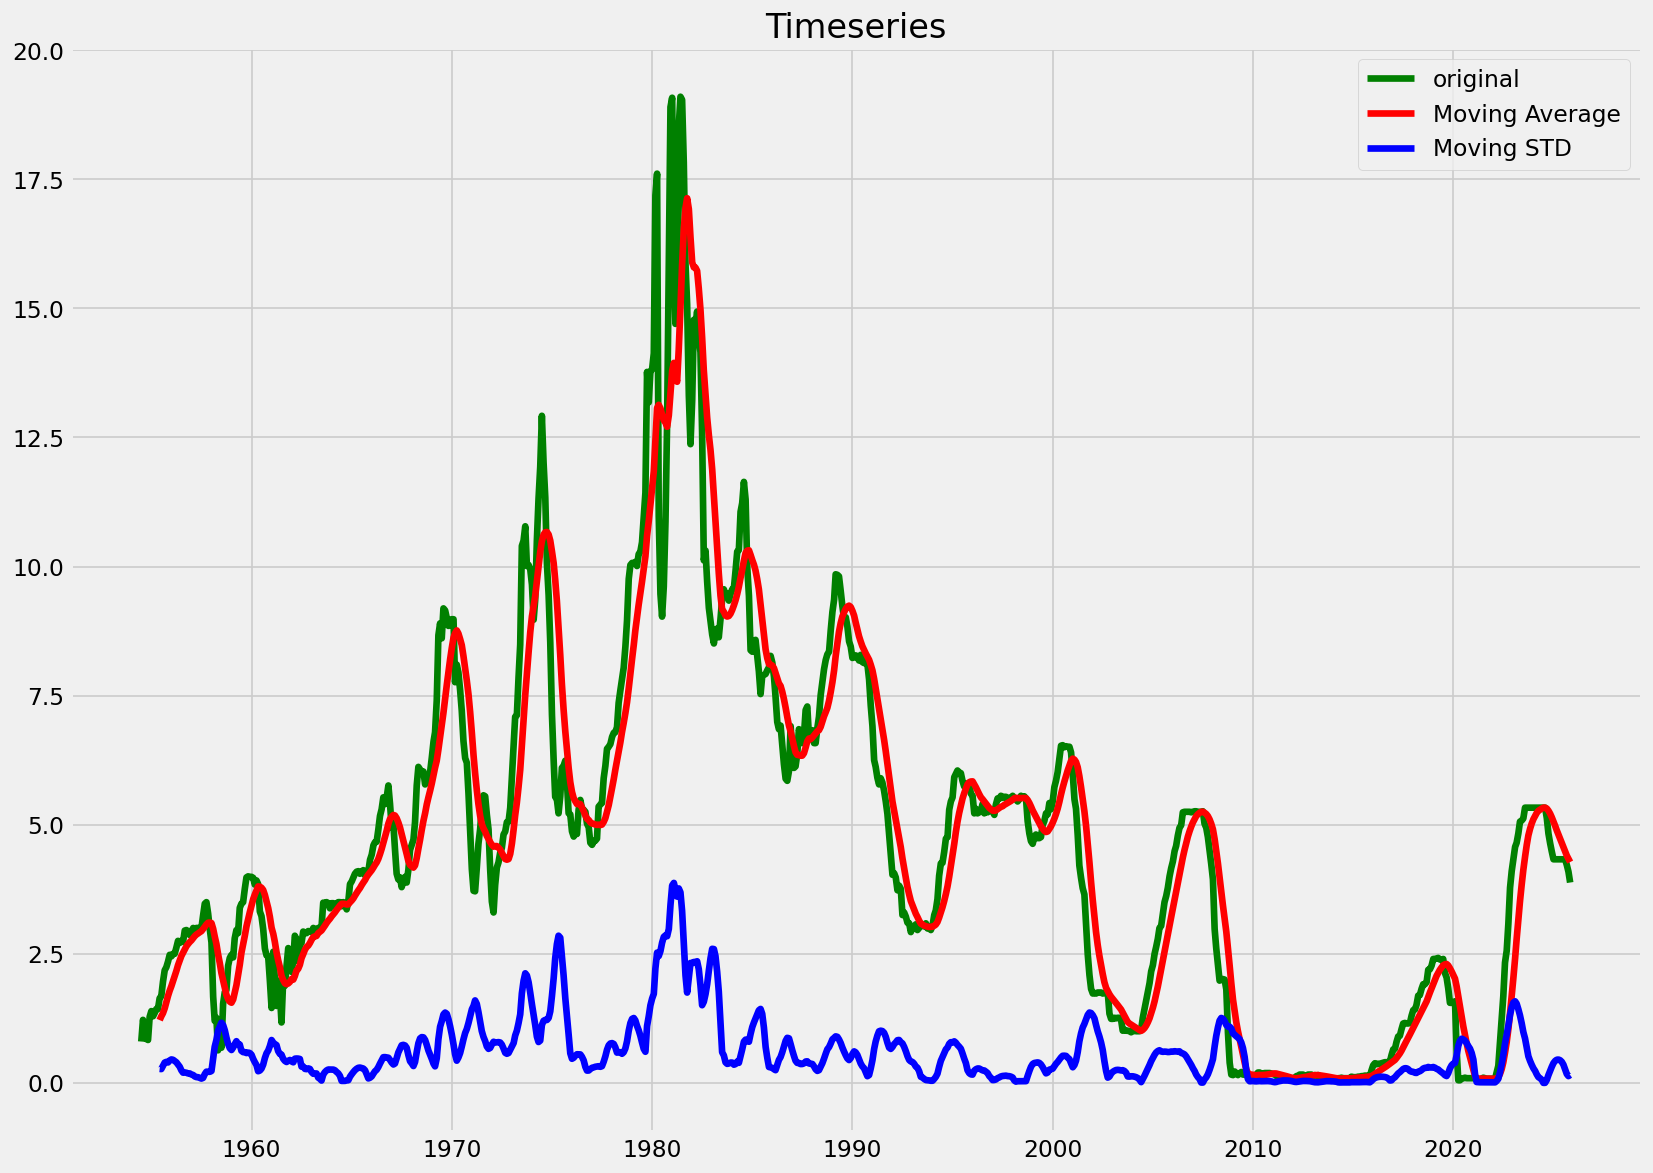


Results from Fueller Tests

Test Statistic                  -2.991685
p-value                          0.035678
'#Lags Used                     17.000000
Number of Observations Used    839.000000
Critical Value (1%)             -3.438168
Critical Value (5%)             -2.864991
Critical Value (10%)            -2.568608
dtype: float64
P-Value
0.035678264860177

# of Lags Used

17


In [78]:
# test stationary of original series

test_stationary(data)




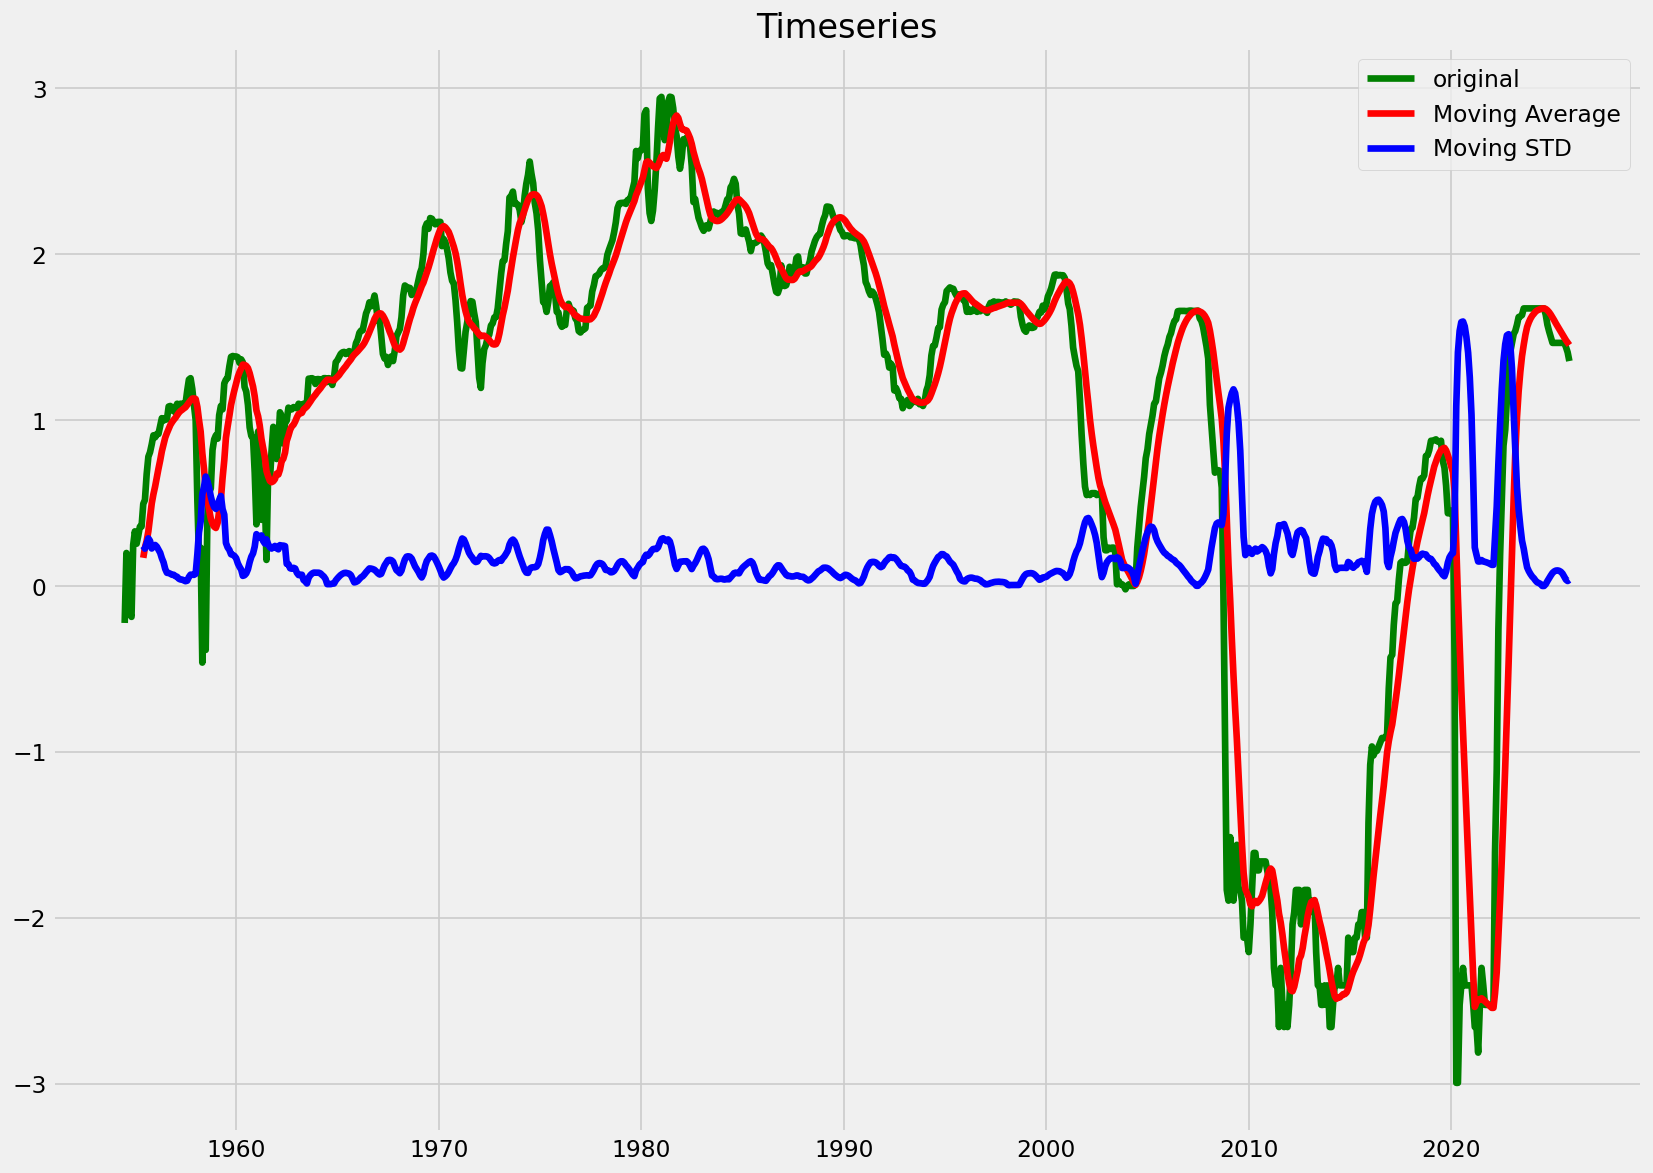


Results from Fueller Tests

Test Statistic                  -2.246856
p-value                          0.189681
'#Lags Used                      1.000000
Number of Observations Used    855.000000
Critical Value (1%)             -3.438021
Critical Value (5%)             -2.864926
Critical Value (10%)            -2.568573
dtype: float64
P-Value
0.18968092541331638

# of Lags Used

1


In [79]:
# log values

log_df = np.log(data).dropna()

test_stationary(log_df)

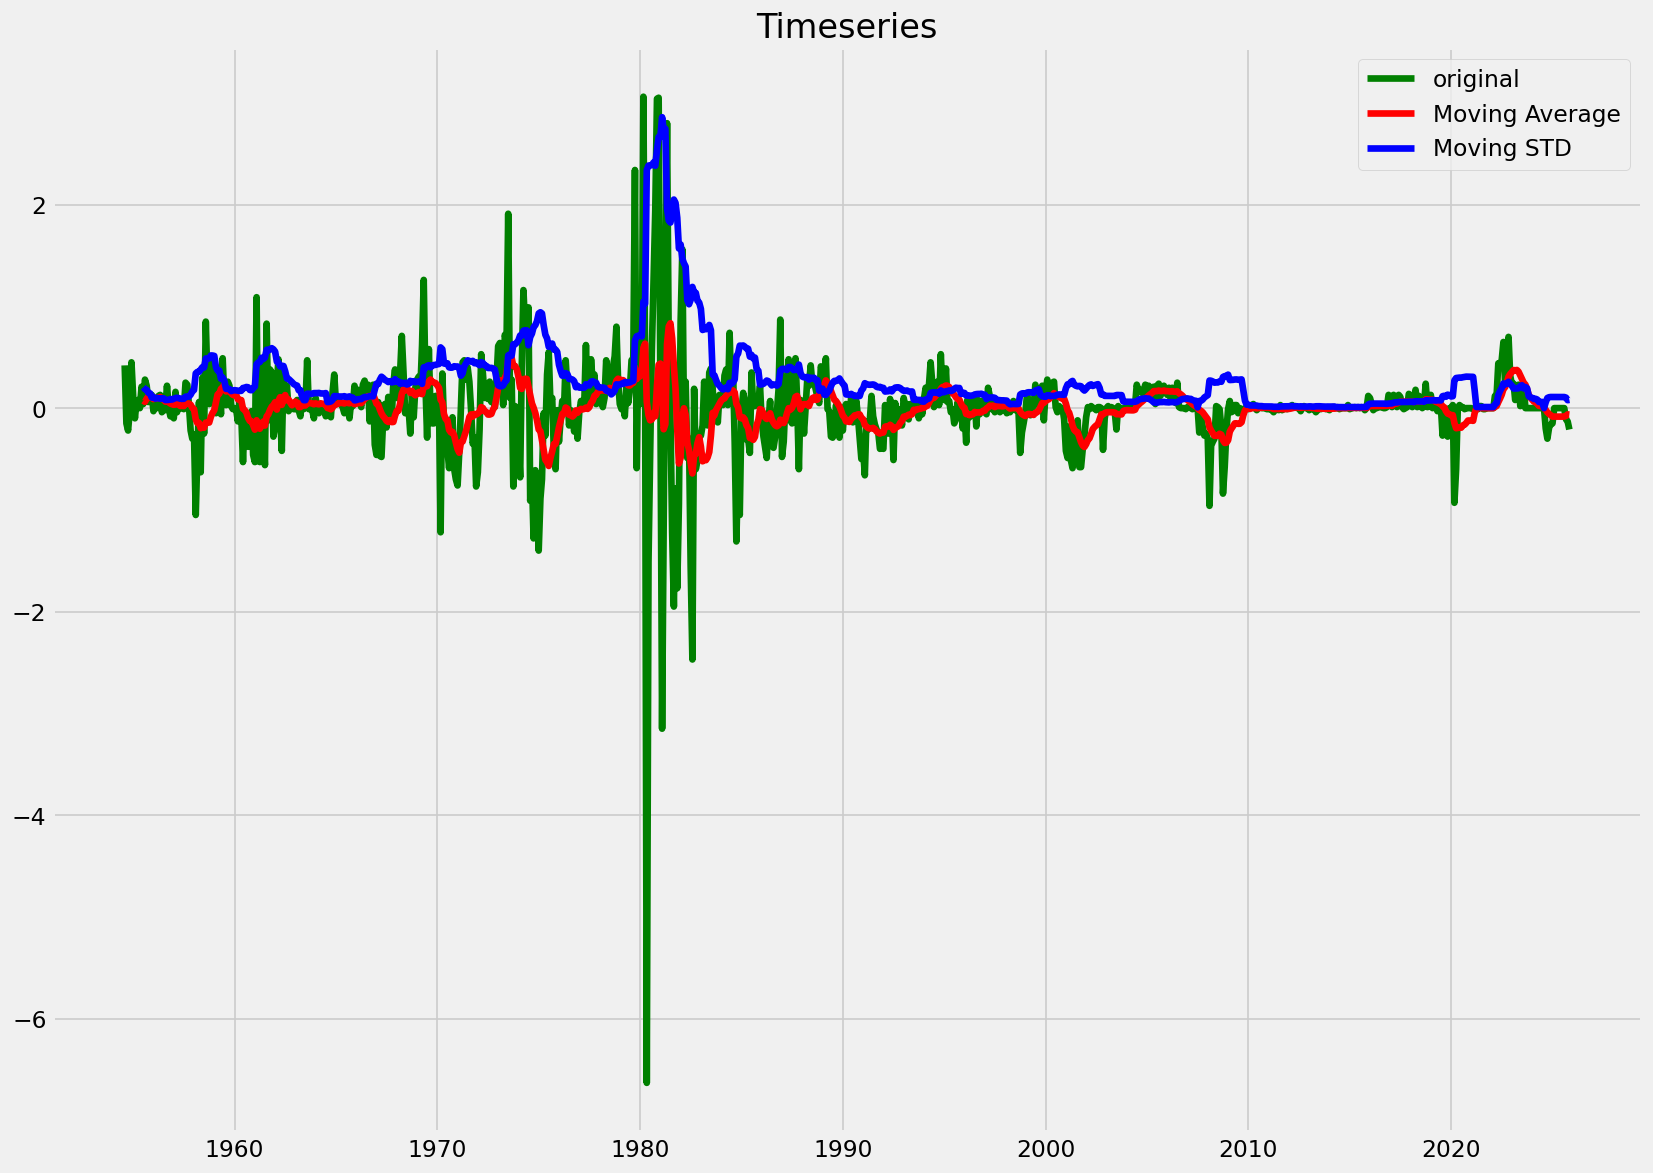


Results from Fueller Tests

Test Statistic                -6.471013e+00
p-value                        1.367176e-08
'#Lags Used                    1.800000e+01
Number of Observations Used    8.370000e+02
Critical Value (1%)           -3.438187e+00
Critical Value (5%)           -2.864999e+00
Critical Value (10%)          -2.568612e+00
dtype: float64
P-Value
1.3671760312355712e-08

# of Lags Used

18


In [80]:
# first-order differencing

df_diff = data.diff().dropna()
test_stationary(df_diff)

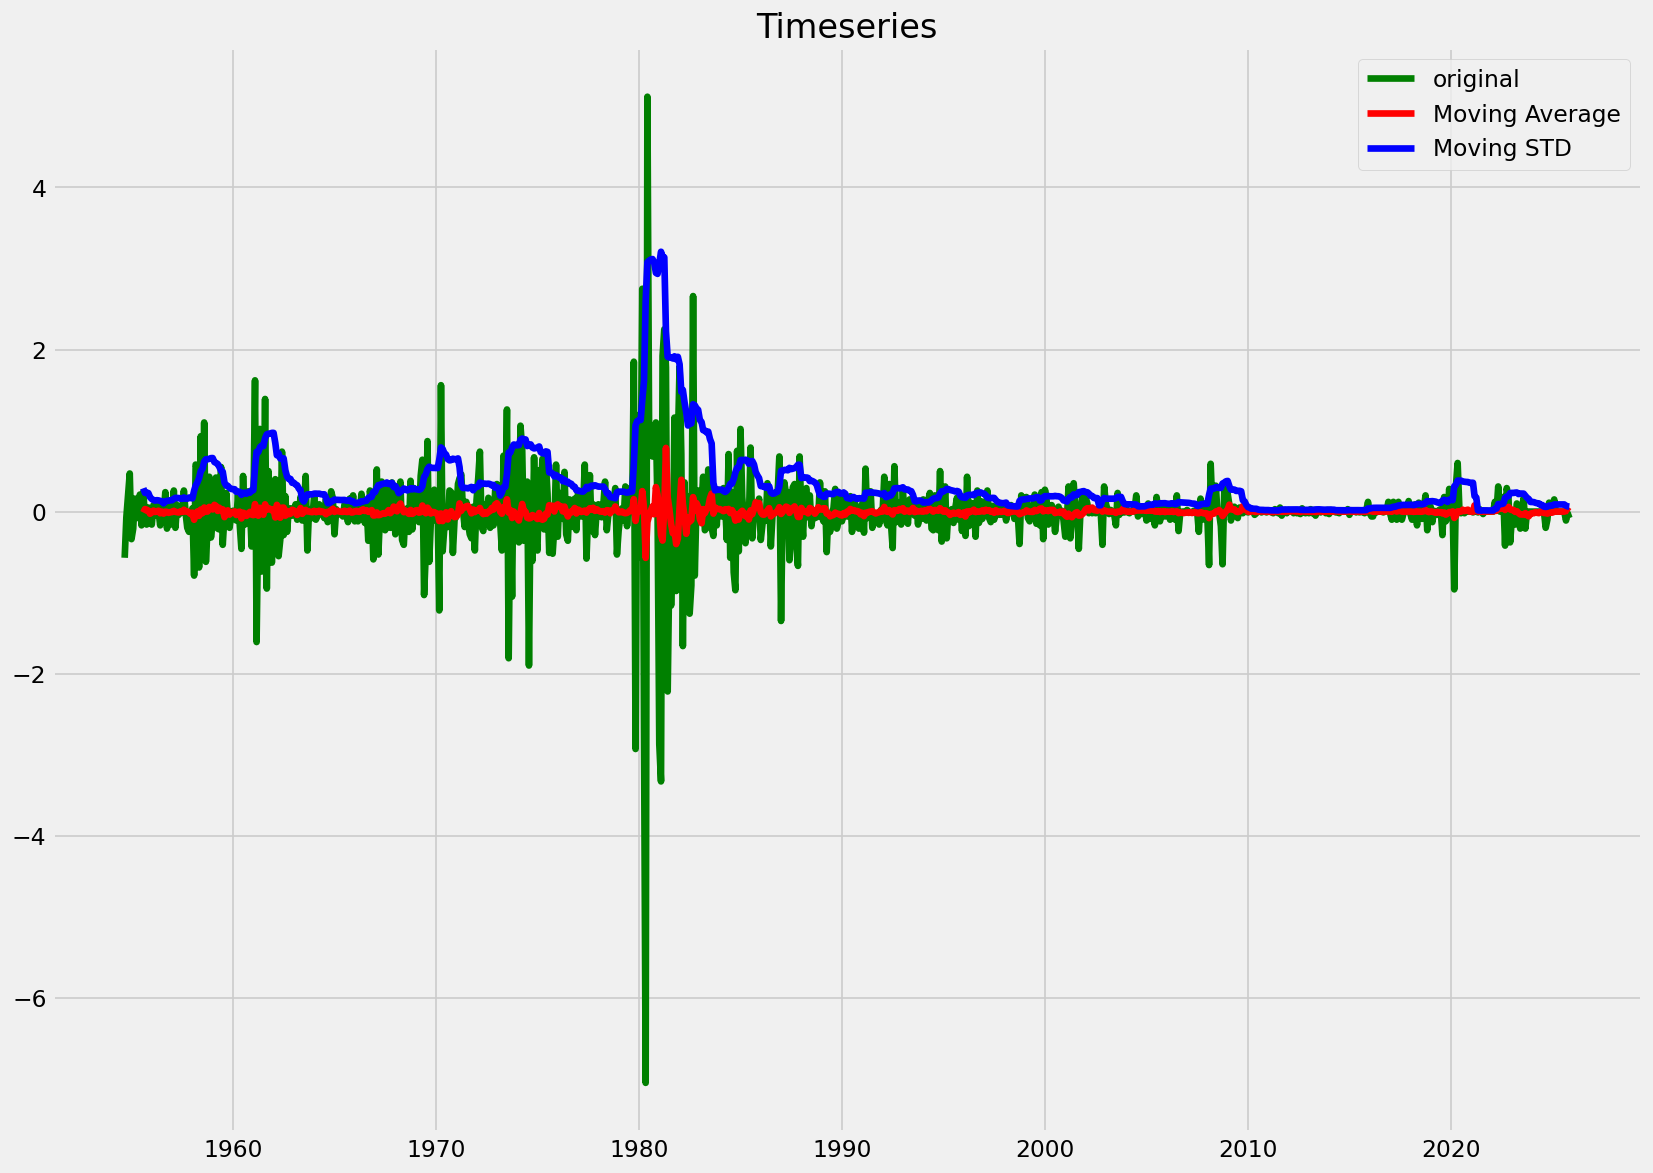


Results from Fueller Tests

Test Statistic                -1.452235e+01
p-value                        5.498067e-27
'#Lags Used                    1.400000e+01
Number of Observations Used    8.400000e+02
Critical Value (1%)           -3.438159e+00
Critical Value (5%)           -2.864987e+00
Critical Value (10%)          -2.568605e+00
dtype: float64
P-Value
5.49806673381452e-27

# of Lags Used

14


In [81]:
# second-order differencing 

df_diff_diff = data.diff().diff().dropna()
test_stationary(df_diff_diff)

* ACF plots for First and Second-order Differencing.

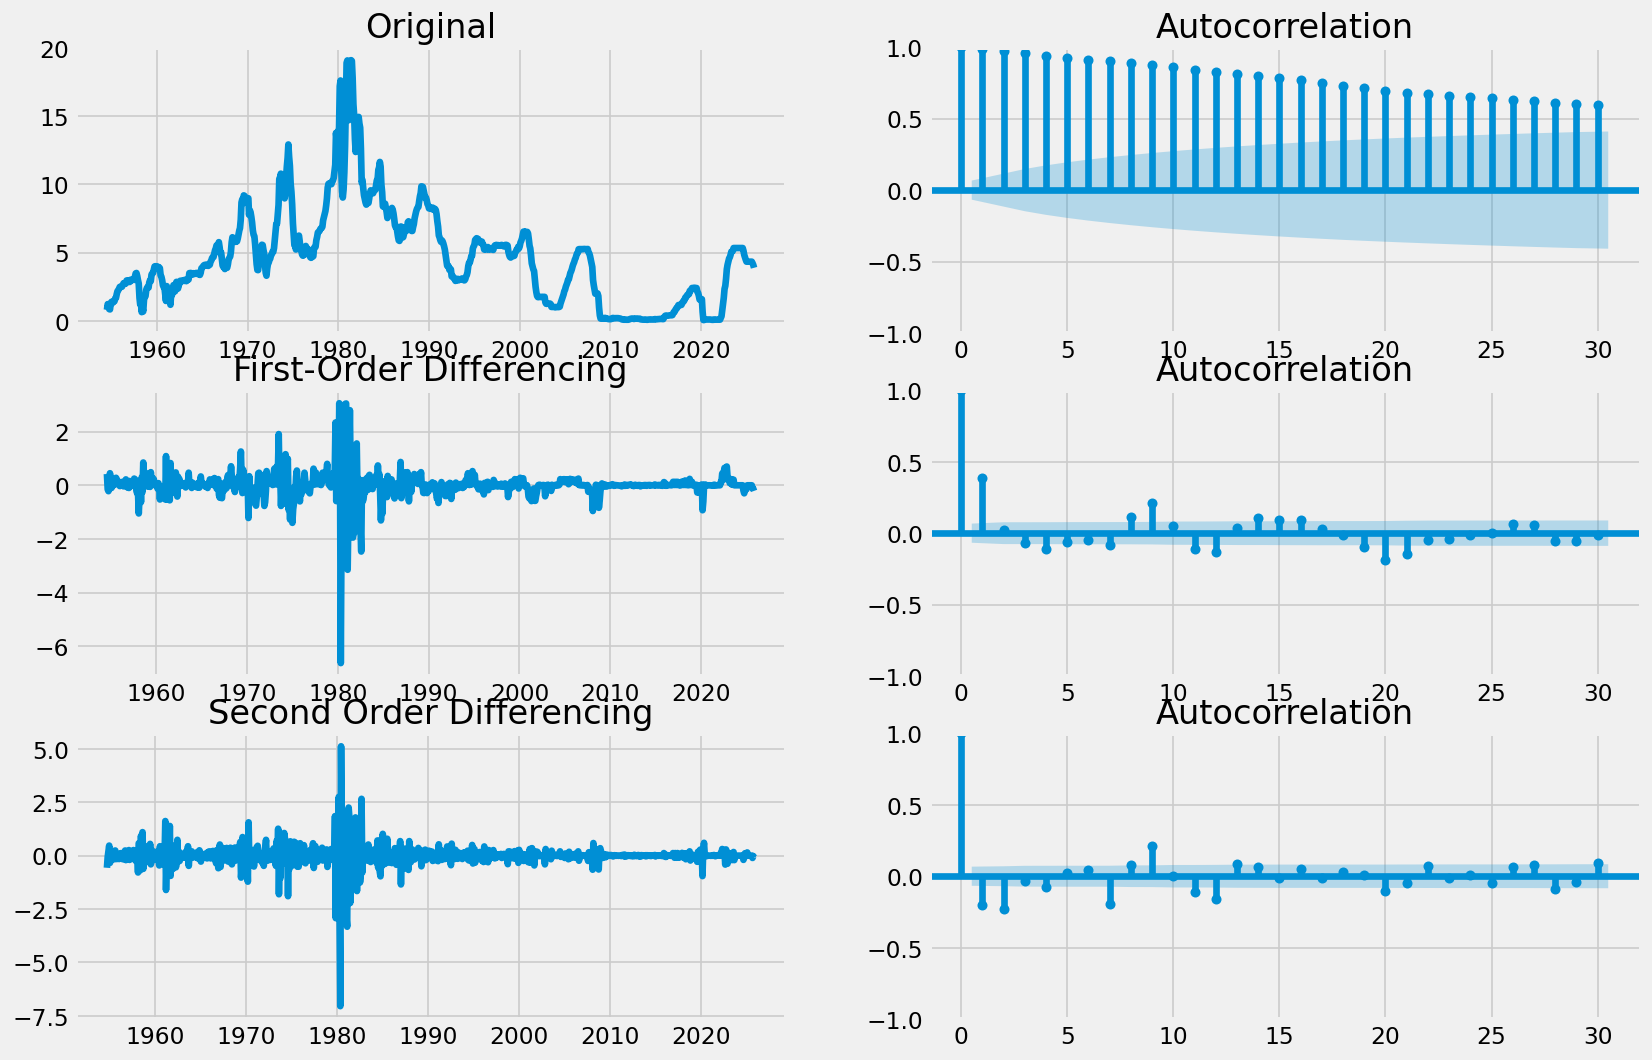

In [82]:
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

fig,axs = plt.subplots(3,2)
# original data points
axs[0,0].plot(data);axs[0,0].set_title("Original")
plot_acf(data,ax=axs[0,1])

# first-order differencing
axs[1,0].plot(data.diff().dropna());axs[1,0].set_title("First-Order Differencing")
plot_acf(data.diff().dropna(),ax=axs[1,1])

# second-order Differencing
axs[2,0].plot(data.diff().diff().dropna());axs[2,0].set_title("Second Order Differencing")
plot_acf(data.diff().diff().dropna(),ax=axs[2,1])
plt.show()








- PACF plots for first and Second-order Differencing.

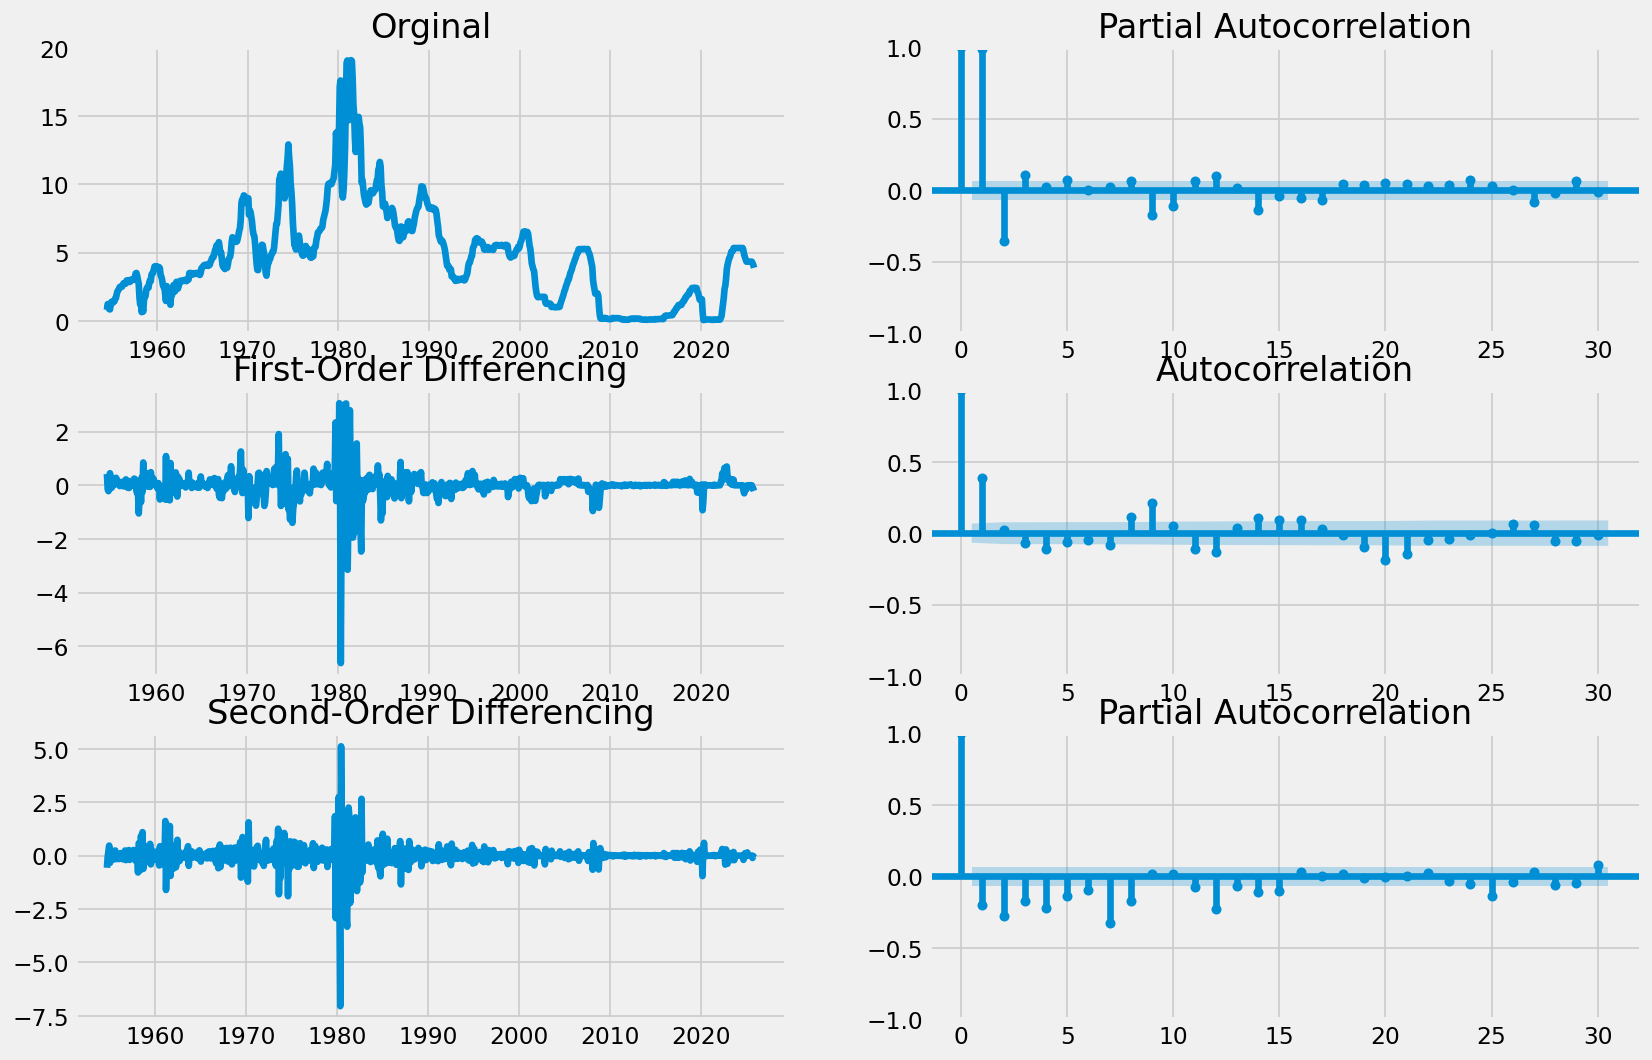

In [83]:

fig,axs = plt.subplots(3,2)
axs[0,0].plot(data);axs[0,0].set_title("Orginal")
plot_pacf(data,ax=axs[0,1])

# first-order differencing
axs[1,0].plot(data.diff().dropna());axs[1,0].set_title("First-Order Differencing")
plot_acf(data.diff().dropna(),ax=axs[1,1])


# Second-Order Differencing
axs[2,0].plot(data.diff().diff().dropna());axs[2,0].set_title("Second-Order Differencing")
plot_pacf(data.diff().diff().dropna(),ax=axs[2,1])
plt.show()

### ARIMA
- Use the results from first-order differencing, second-order differencing, ACF, and pacf to determine best values for ARIMA forecast.

In [84]:
# Order(1,1,1)
results = ARIMA(data,order=(1,1,1))
fitted_results = results.fit()
fitted_results.summary()

/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  857
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -509.307
Date:                Fri, 05 Dec 2025   AIC                           1024.613
Time:                        17:34:14   BIC                           1038.870
Sample:                    07-01-1954   HQIC                          1030.072
                         - 11-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1037      0.035      3.003      0.003       0.036       0.171
ma.L1          0.3439      0.036      9.674      0.000       0.274       0.414
sigma2         0.1924      0.003     64.544      0.000       0.187       0.198
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            126991.99
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -3.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
# ARIMA Order(2,2,2)
results = ARIMA(data,order=(2,2,2))
results_fitted = results.fit()
results_fitted.summary()

/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  857
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -510.607
Date:                Fri, 05 Dec 2025   AIC                           1031.214
Time:                        17:34:20   BIC                           1054.970
Sample:                    07-01-1954   HQIC                          1040.311
                         - 11-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8530      0.093      9.126      0.000       0.670       1.036
ar.L2         -0.3019      0.036     -8.492      0.000      -0.372      -0.232
ma.L1         -1.4191      0.153     -9.288      0.000      -1.718      -1.120
ma.L2          0.4191      0.102      4.106      0.000       0.219       0.619
sigma2         0.1919      0.028      6.868      0.000       0.137       0.247
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            136129.38
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -3.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        64.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

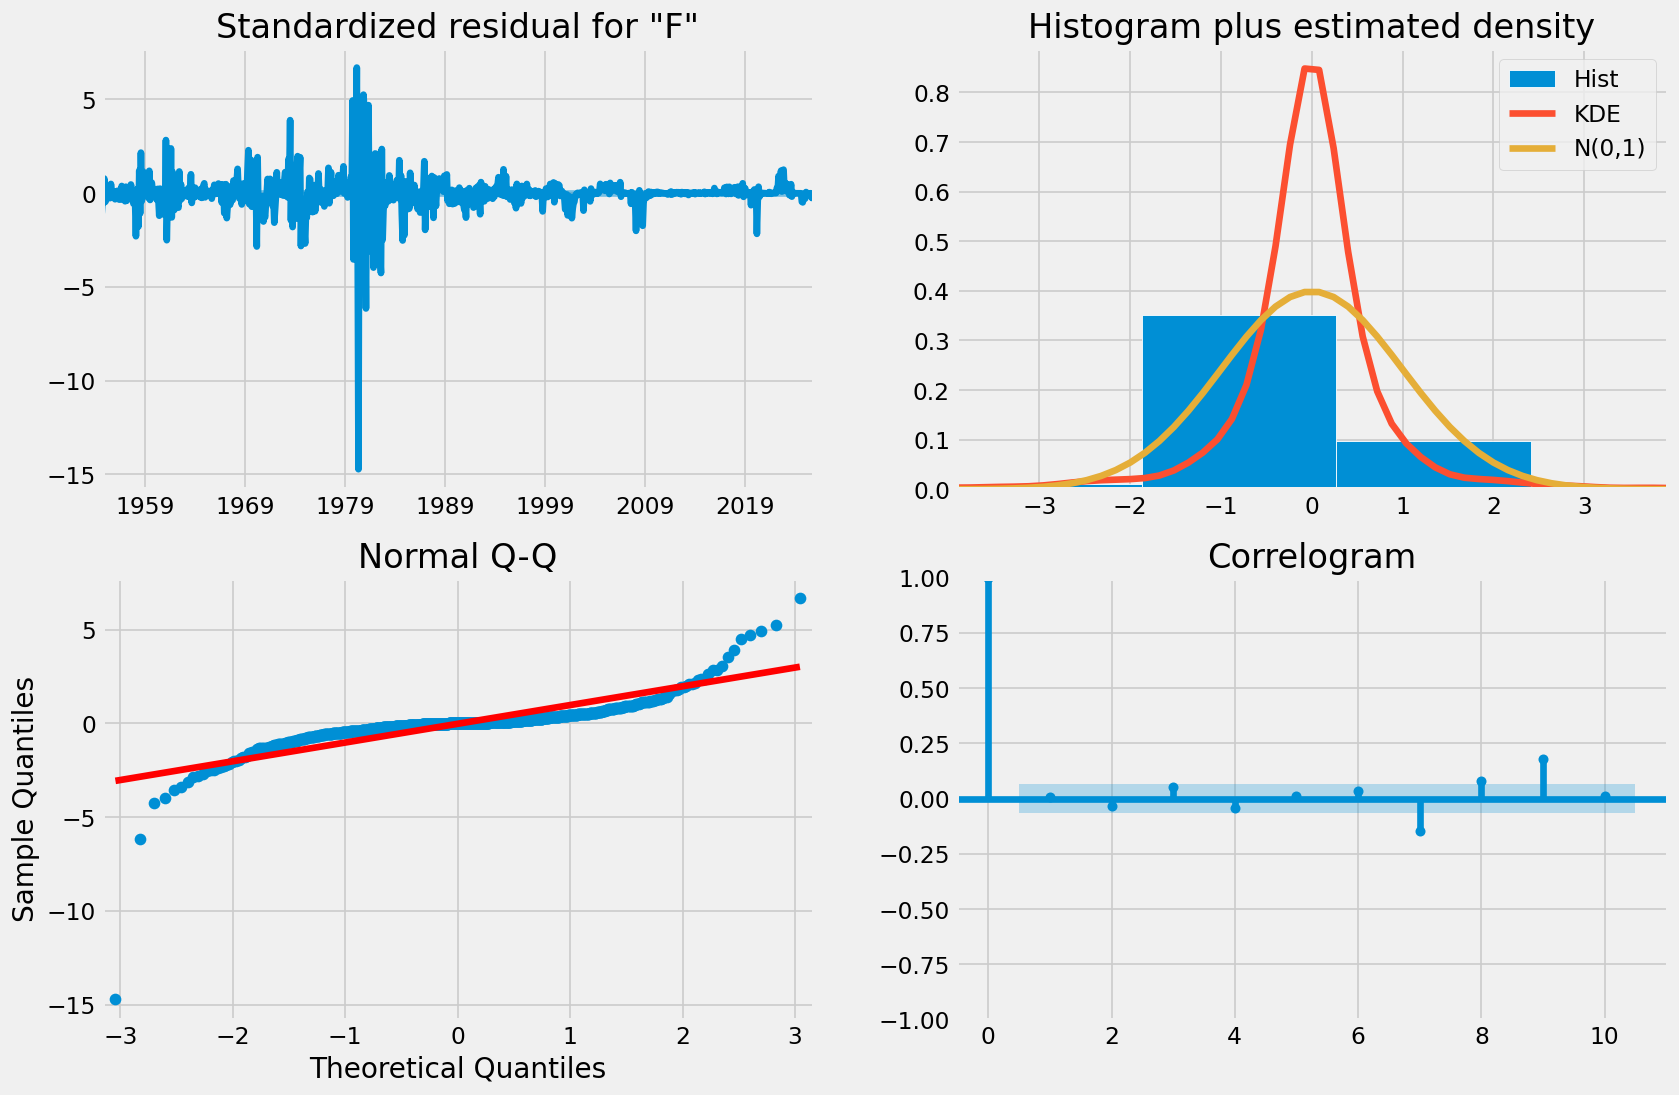

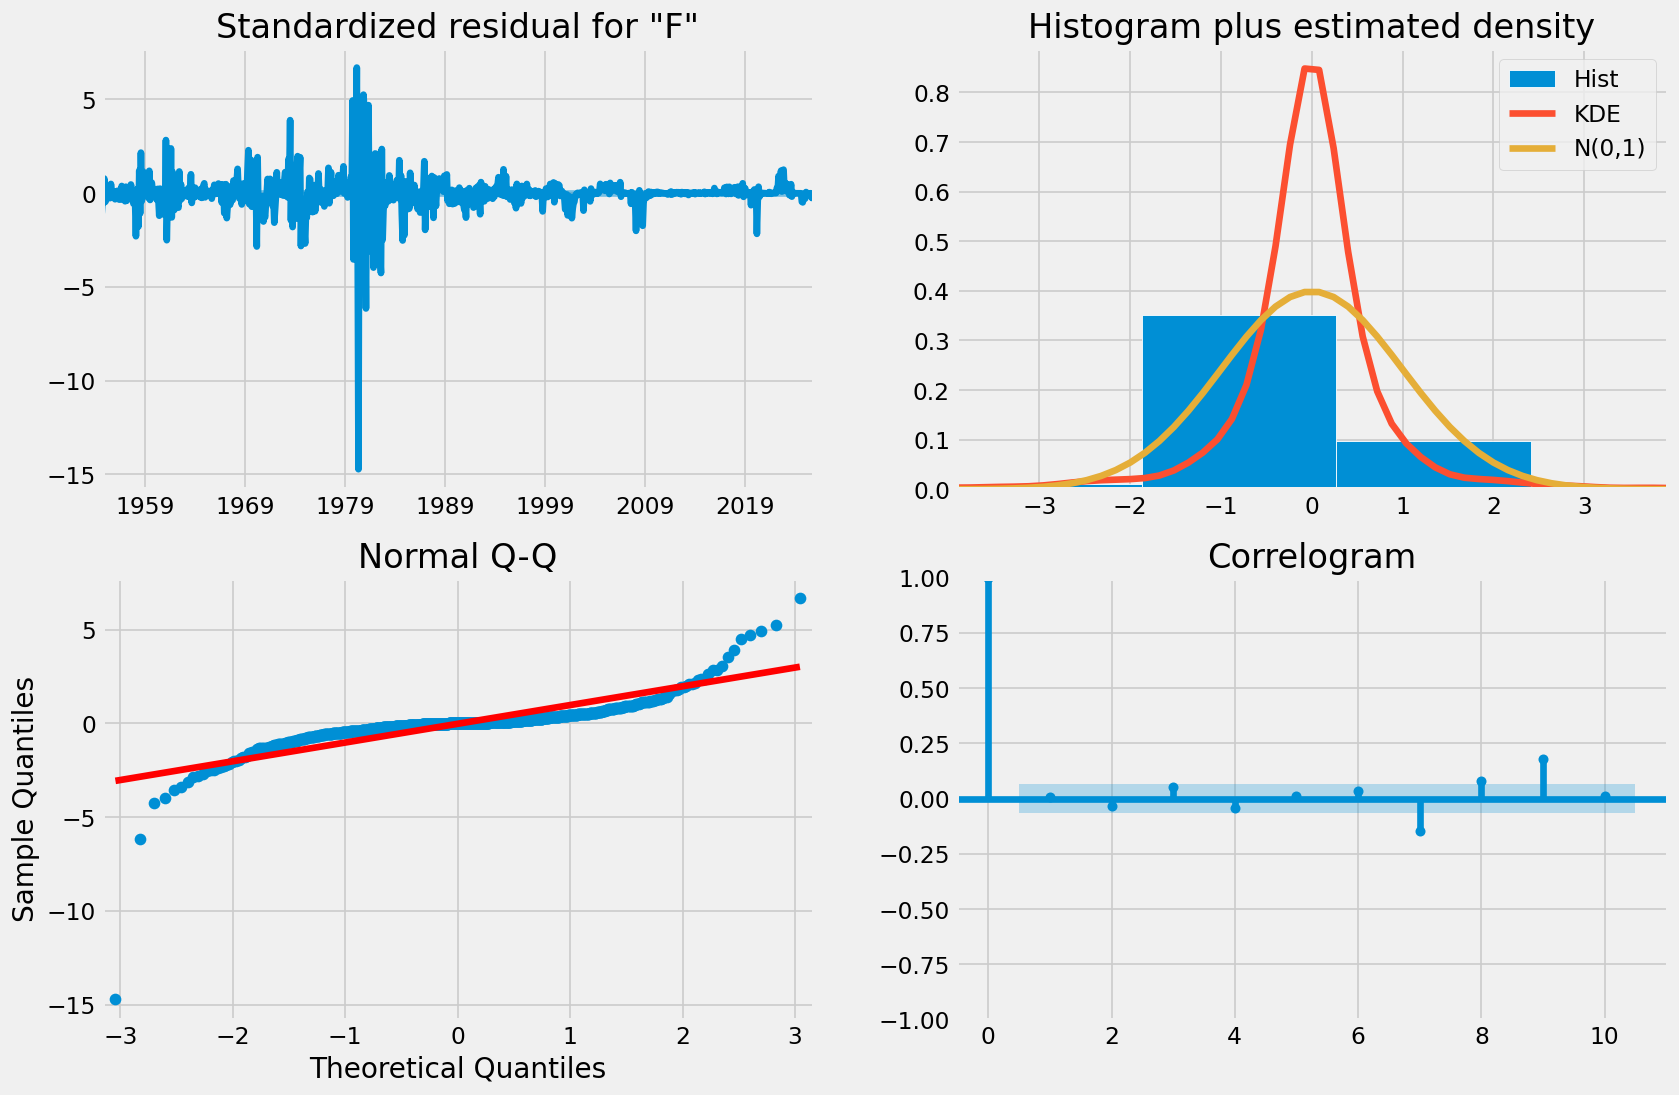

In [86]:
# plot of results
results_fitted.plot_diagnostics()



<Axes: >

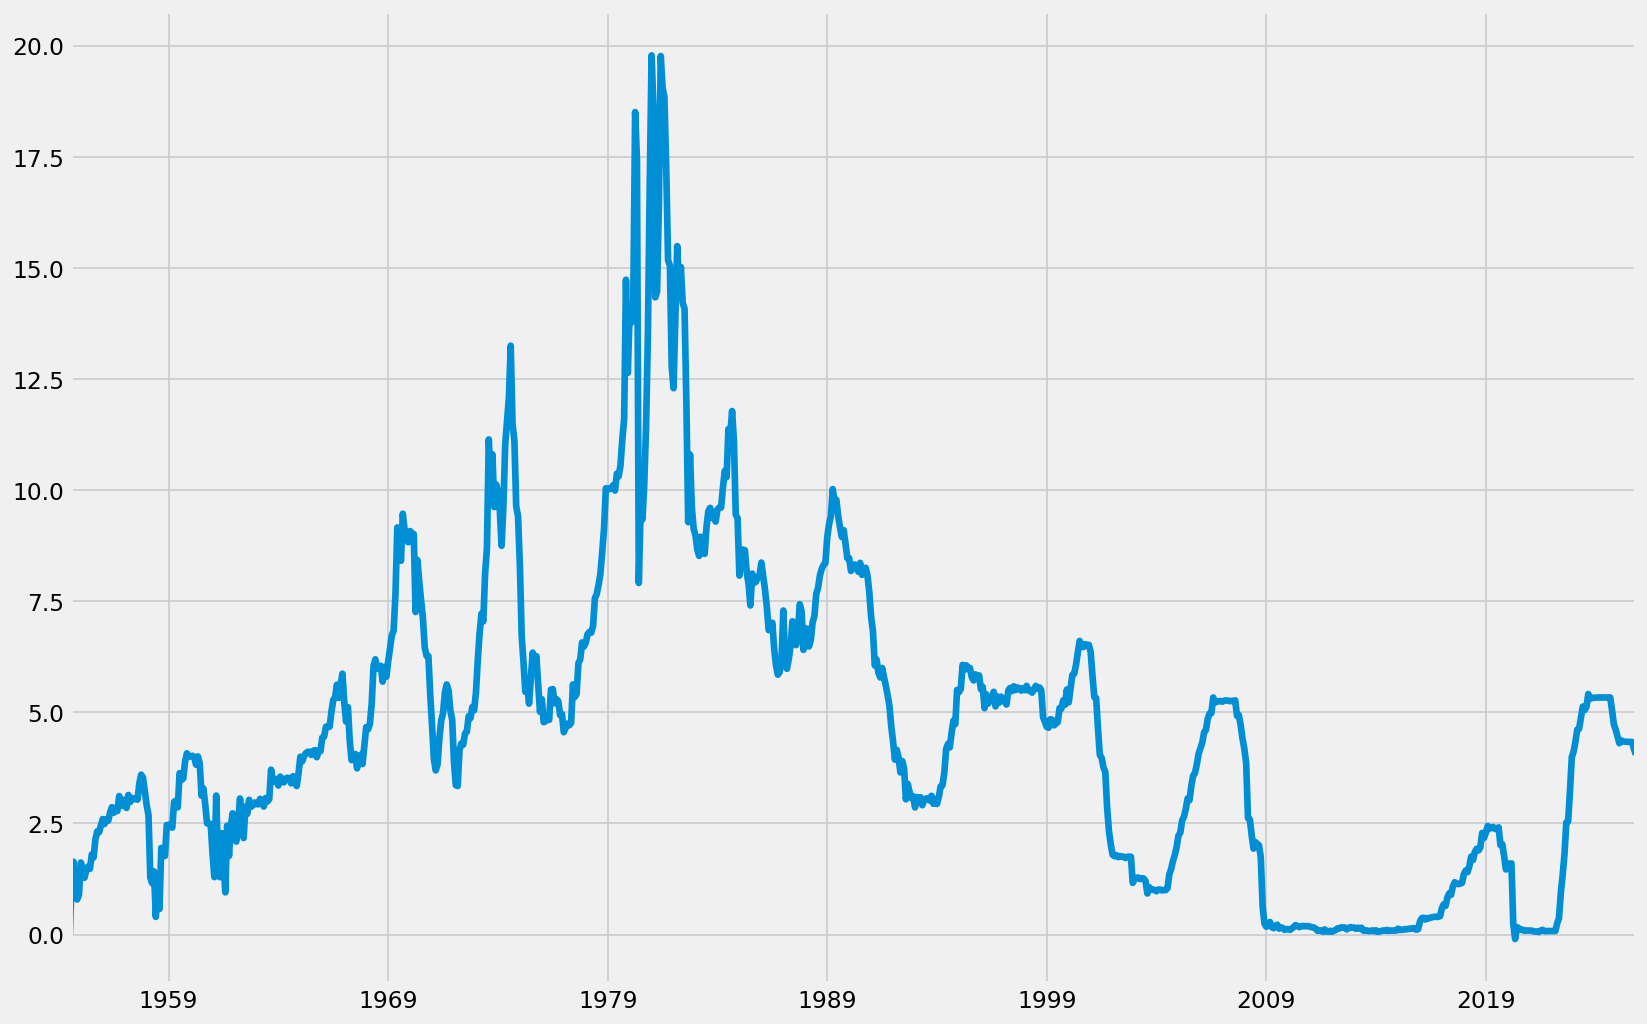

In [87]:
# predictions using ARIMA
result_predict = results_fitted.predict()
result_predict.plot()



- split data for forecast

In [88]:
train = data[171:]
test = data[:171]
print(f"length of training data: {len(train)}")
print(f"Length of Testing Data: {len(test)}")

length of training data: 686
Length of Testing Data: 171
